<a href="https://colab.research.google.com/github/minzix/garbage_sorting/blob/main/EfficientNet(Multi_label).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, Subset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import re
import os
import random
import torch.nn.functional as F
from sklearn.metrics import multilabel_confusion_matrix

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


## (Multi-label) Custom Dataset Class 구현

In [ ]:
!ls "/content/drive/MyDrive/2023-1_DL/Project/dataset_full"

cardboard  glass  metal  paper	plastic  trash


In [ ]:
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
def to_device(data, device): # Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
def denorm(img_tensors): # denormalize the tensors
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

In [ ]:
# Multi-label image의 class들을 shape (6)의 Tensor로 Encoding
def encode_label(label, classes_list = class_labels)
    target = torch.zeros(len(class_labels))
    for l in label:
      idx = classes_list.index(l)
      target[idx] = 1
    return target

# 0과 1 형태의 Prediciton Tensor를 text 형태로 Decoding
def decode_target(target, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(class_labels[i])
    return ' '.join(result)

In [ ]:
def show_example(img,label):
  plt.imshow(denorm(img).permute(1,2,0))
  print("Label:", decode_target(label))
  print()
  print(label)

In [ ]:
# root_dir 입력 시 하위에 있는 image들의 전체 path를 가진 list를 리턴함
def get_path_names(dir):
  images = []
  for path, subdirs, files in os.walk(data_dir):
    for name in files:
      #print(os.path.join(path, name))
      images.append(os.path.join(path, name))
  return images

In [ ]:
# Multi-label dataset 경로
data_dir = '/content/drive/MyDrive/2023_DeepLearning/dataset_merged'

In [ ]:
len(get_path_names(data_dir)) # Multi-label images 개수

5000

In [ ]:
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = img_path.split('/')[-1].split('_')[0].split('+')

        return img, encode_label(label)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

multi_label_dataset = myDataset(data_dir, transform = transform)
len(multi_label_dataset)

5000

In [ ]:
# 2개의 labels가 나오는 것을 확인할 수 있음
multi_label_dataset[1]

(tensor([[[1.6667, 1.6667, 1.6324,  ..., 1.7694, 1.7523, 1.7523],
          [1.6667, 1.6667, 1.6153,  ..., 1.7694, 1.7523, 1.7523],
          [1.6667, 1.6495, 1.5810,  ..., 1.7694, 1.7523, 1.7523],
          ...,
          [1.7180, 1.6838, 1.6495,  ..., 0.9988, 0.9817, 0.9817],
          [1.7180, 1.6838, 1.6495,  ..., 0.9988, 0.9817, 0.9646],
          [1.7180, 1.6838, 1.6495,  ..., 0.9988, 0.9817, 0.9646]],
 
         [[1.8333, 1.8333, 1.7983,  ..., 1.7283, 1.7108, 1.7108],
          [1.8333, 1.8333, 1.7808,  ..., 1.7283, 1.7108, 1.7108],
          [1.8333, 1.8158, 1.7283,  ..., 1.7283, 1.7108, 1.7108],
          ...,
          [1.8859, 1.8508, 1.8158,  ..., 0.9405, 0.9230, 0.9230],
          [1.8859, 1.8508, 1.8158,  ..., 0.9405, 0.9230, 0.9055],
          [1.8859, 1.8508, 1.8158,  ..., 0.9405, 0.9230, 0.9055]],
 
         [[2.0823, 2.0823, 2.0474,  ..., 1.6988, 1.6814, 1.6814],
          [2.0823, 2.0823, 2.0300,  ..., 1.6988, 1.6814, 1.6814],
          [2.0823, 2.0648, 1.9951,  ...,

Label: cardboard plastic

tensor([1., 0., 0., 0., 1., 0.])


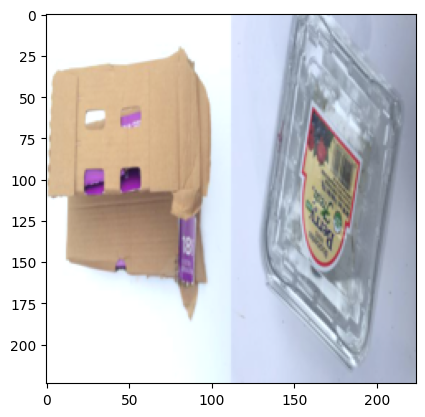

In [ ]:
show_example(*multi_label_dataset[2782])

### train, valid, test split

In [ ]:
num_data = len(multi_label_dataset)
indices = list(range(num_data))

split_ratio = [0.6, 0.2, 0.2]  # train, test, valid 데이터셋의 비율

random.shuffle(indices)  # 인덱스를 무작위로 섞음

train_split = int(num_data * split_ratio[0])
test_split = int(num_data * (split_ratio[0] + split_ratio[1]))

train_indices = indices[:train_split]
test_indices = indices[train_split:test_split]
valid_indices = indices[test_split:]

# Subset을 사용하여 train, test, valid 데이터셋 생성
train_dataset = Subset(multi_label_dataset, train_indices)
test_dataset = Subset(multi_label_dataset, test_indices)
valid_dataset = Subset(multi_label_dataset, valid_indices)

# 데이터로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32, 6])


## (기존) 데이터 로드, 이미지 시각화

In [ ]:
# train, valid, test로 분리

# 데이터셋 디렉토리 경로
dataset_dir = "/content/drive/MyDrive/2023-1_DL/Project/dataset_full"

# 클래스 레이블과 해당 폴더의 이미지 경로 가져오기
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
image_paths = []

for label in class_labels:
    folder_path = os.path.join(dataset_dir, label)
    images = os.listdir(folder_path)
    images = [os.path.join(folder_path, image) for image in images]
    image_paths.extend(images)

# 전처리된 이미지 데이터와 클래스 레이블을 Tensor로 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 전체 데이터셋을 로드
dataset = torchvision.datasets.ImageFolder(dataset_dir, transform=transform)

# 데이터셋을 train, test, valid로 나누기 위해 인덱스 생성
num_data = len(dataset)
indices = list(range(num_data))

split_ratio = [0.6, 0.2, 0.2]  # train, test, valid 데이터셋의 비율

random.shuffle(indices)  # 인덱스를 무작위로 섞음

train_split = int(num_data * split_ratio[0])
test_split = int(num_data * (split_ratio[0] + split_ratio[1]))

train_indices = indices[:train_split]
test_indices = indices[train_split:test_split]
valid_indices = indices[test_split:]

# Subset을 사용하여 train, test, valid 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
valid_dataset = Subset(dataset, valid_indices)

# 데이터로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

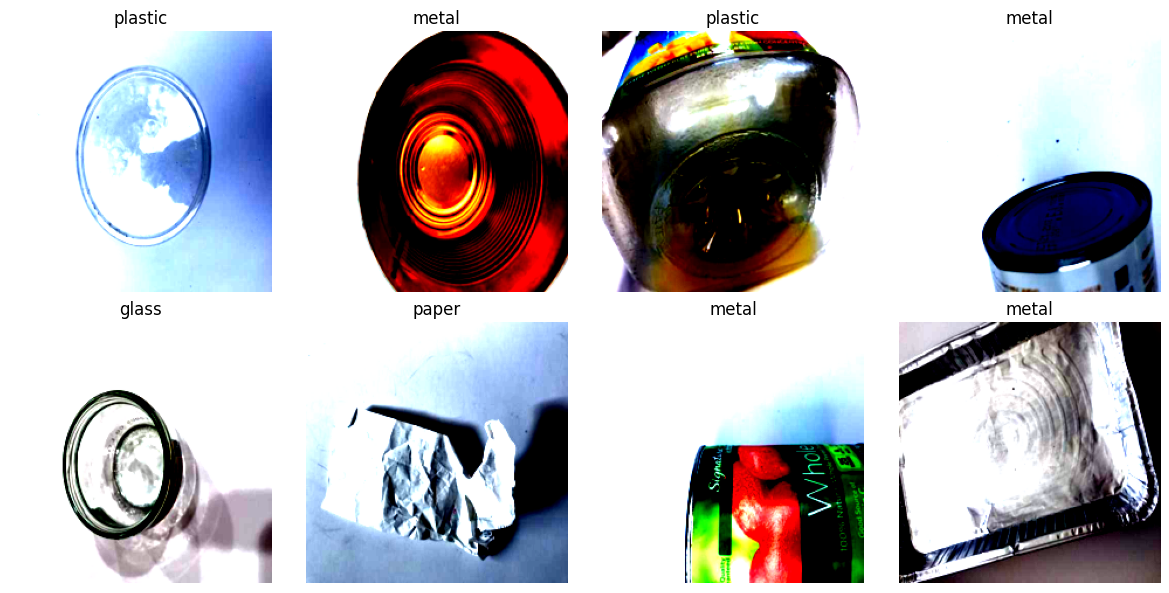

In [ ]:
import matplotlib.pyplot as plt

# 이미지 시각화
def visualize_images(dataset, class_labels):
    num_images = 8  # 시각화할 이미지 개수
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flatten()):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # 이미지 차원 변환 (C, H, W) -> (H, W, C)
        label = class_labels[label]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# train 데이터셋에서 이미지 시각화
visualize_images(train_dataset, class_labels)


In [ ]:
# 데이터 분포 시각화 (돌려봐야함)
def visualize_data_distribution(dataset, class_labels):
    num_images = [0] * len(class_labels)
    for _, label in dataset:
        num_images[label] += 1
    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, num_images)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title("Data Distribution")
    plt.show()

# train 데이터셋의 데이터 분포 시각화
visualize_data_distribution(train_dataset, class_labels)


NameError: name 'train_dataset' is not defined

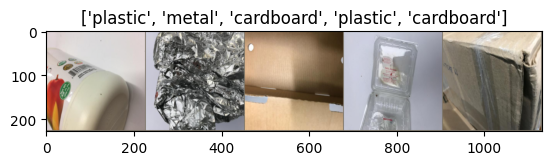

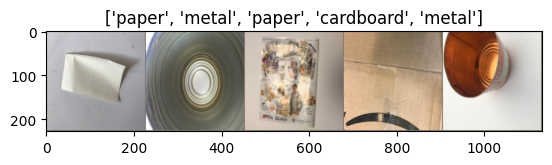

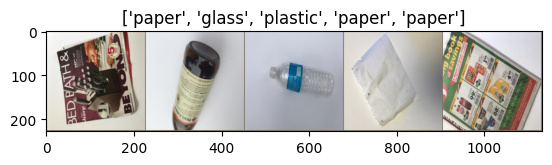

In [ ]:
# 데이터 확인
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    "0": "cardboard",
    "1": "glass",
    "2": "metal",
    "3": "paper",
    "4": "plastic",
    "5": "trash",
}

# train check
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(valid_loader))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(test_loader))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

## (Multi-label) train, evaluate 함수 구현

In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
# 모델 학습 함수
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_score = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda() # torch.Size([32])
        # labels = F.one_hot(labels, num_classes=6) # 모델 outputs과 size 맞추기 위해 one-hot encoding 수행

        optimizer.zero_grad()
        outputs = model(images) # torch.Size([32, 6])
        ###
        #print('labels:', labels, '\noutputs: ', outputs)
        #print('labels size:', labels.size(), 'outputs size: ', outputs.size())
        ###
        loss = criterion(outputs, labels) # .float()
        score = F_score(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_score += score
        #_, predicted = outputs.max(1) # max -> 젤 큰거 하나만 가져옴 ㅡㅡ => acc 계산에 쓰임
        # predicted = F.one_hot(predicted, num_classes=6)
        ###
        #print('predicted: ', predicted)
        ###
        #total += labels.size(0)
        #correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_score /= len(train_loader)
    #train_acc = correct / total

    return train_loss, train_score

# 모델 평가 함수
def evaluate(model, data_loader, criterion):
    model.eval()
    eval_loss = 0.0
    eval_score = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda()
            labels = labels.cuda()
            # labels = F.one_hot(labels, num_classes=6)

            outputs = model(images)
            loss = criterion(outputs, labels) # .float()
            score = F_score(outputs, labels)

            eval_loss += loss.item()
            eval_score += score
            #_, predicted = outputs.max(1)
            # predicted = F.one_hot(predicted, num_classes=6)
            #total += labels.size(0)
            #correct += predicted.eq(labels).sum().item()

    eval_loss /= len(data_loader)
    eval_score /= len(data_loader)
    #eval_acc = correct / total

    return eval_loss, eval_score

## (단일-label) Fine tuning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt

# EfficientNet 모델 불러오기
model = efficientnet_b0(pretrained=True)
num_classes = len(class_labels)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# fine tuning
for param in model.parameters():
    param.requires_grad = True

# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss() # Multi-label Classification을 위해 BinaryCE로 변경
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 50
train_losses = []
train_accs = []
eval_losses = []
eval_accs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # train으로 학습, valid로 평가
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    eval_loss, eval_acc = evaluate(model, valid_loader, criterion)
    # 그래프 그리기 위한 append
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Eval Loss: {eval_loss:.4f} | Eval Acc: {eval_acc:.4f}')
    #print(f'Eval Loss: {eval_loss:.4f}')
    print('---------------------------------------')

# 테스트 데이터로 모델 평가
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Epoch 1/50
Train Loss: 0.2153 | Train Acc: 5.5345
Eval Loss: 0.1510 | Eval Acc: 5.6654
---------------------------------------
Epoch 2/50
Train Loss: 0.0898 | Train Acc: 5.8028
Eval Loss: 0.0819 | Eval Acc: 5.8465
---------------------------------------
Epoch 3/50
Train Loss: 0.0624 | Train Acc: 5.8698
Eval Loss: 0.0989 | Eval Acc: 5.8307
---------------------------------------
Epoch 4/50
Train Loss: 0.0565 | Train Acc: 5.8922
Eval Loss: 0.1112 | Eval Acc: 5.8189
---------------------------------------
Epoch 5/50
Train Loss: 0.0534 | Train Acc: 5.8961
Eval Loss: 0.0976 | Eval Acc: 5.8346
---------------------------------------
Epoch 6/50
Train Loss: 0.0407 | Train Acc: 5.9237
Eval Loss: 0.0723 | Eval Acc: 5.8504
---------------------------------------
Epoch 7/50
Train Loss: 0.0359 | Train Acc: 5.9448
Eval Loss: 0.1086 | Eval Acc: 5.8110
---------------------------------------
Epoch 8/50
Train Loss: 0.0347 | Train Acc: 5.9356
Eval Loss: 0.0667 | Eval Acc: 5.8740
------------------------

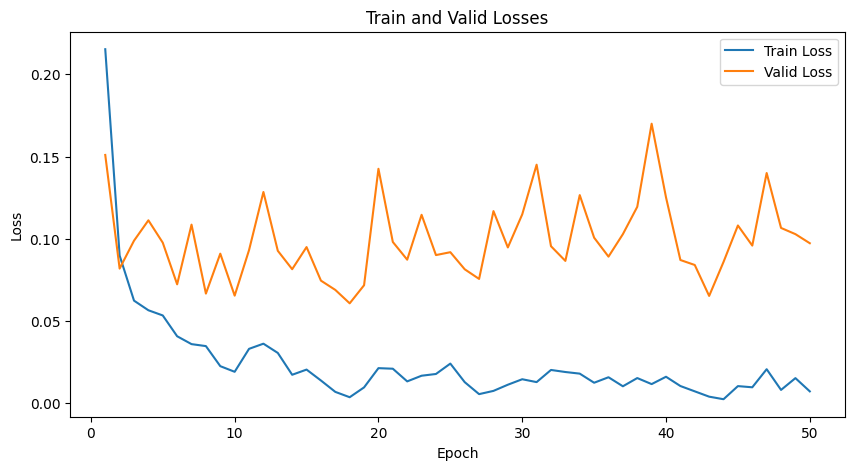

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), eval_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Losses')
plt.legend()
plt.show()

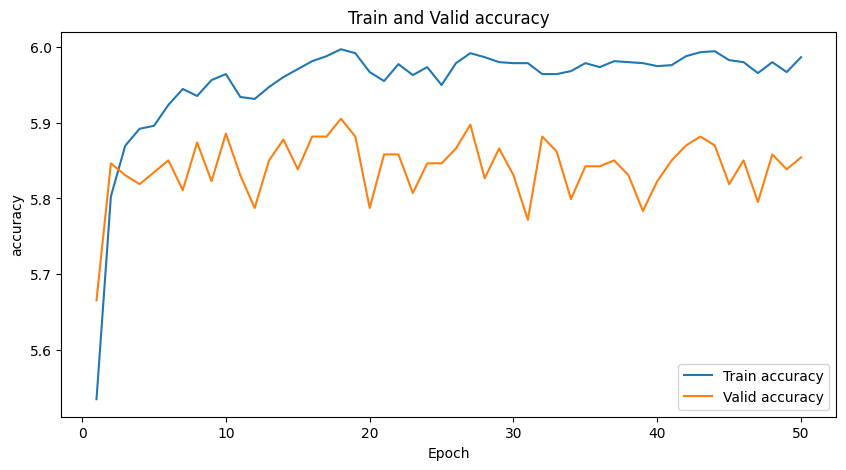

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accs, label='Train accuracy')
plt.plot(range(1, num_epochs+1), eval_accs, label='Valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Train and Valid accuracy')
plt.legend()
plt.show()

## (Multi-label) Fine tuning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt

# EfficientNet 모델 불러오기
model = efficientnet_b0(pretrained=True)
num_classes = len(class_labels)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# fine tuning
for param in model.parameters():
    param.requires_grad = True

# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss() # Multi-label Classification을 위해 BinaryCE로 변경
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 50
train_losses = []
train_accs = []
eval_losses = []
eval_accs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # train으로 학습, valid로 평가
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    eval_loss, eval_acc = evaluate(model, valid_loader, criterion)
    # 그래프 그리기 위한 append
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Score: {train_acc:.4f}')
    print(f'Eval Loss: {eval_loss:.4f} | Eval Score: {eval_acc:.4f}')
    #print(f'Eval Loss: {eval_loss:.4f}')
    print('---------------------------------------')

# 테스트 데이터로 모델 평가
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Score: {test_acc:.4f}')

Epoch 1/50
Train Loss: 0.0351 | Train Score: 0.9825
Eval Loss: 0.0708 | Eval Score: 0.9733
---------------------------------------
Epoch 2/50
Train Loss: 0.0181 | Train Score: 0.9906
Eval Loss: 0.0363 | Eval Score: 0.9837
---------------------------------------
Epoch 3/50
Train Loss: 0.0233 | Train Score: 0.9885
Eval Loss: 0.0458 | Eval Score: 0.9805
---------------------------------------
Epoch 4/50
Train Loss: 0.0237 | Train Score: 0.9892
Eval Loss: 0.0433 | Eval Score: 0.9838
---------------------------------------
Epoch 5/50
Train Loss: 0.0315 | Train Score: 0.9864
Eval Loss: 0.0580 | Eval Score: 0.9739
---------------------------------------
Epoch 6/50
Train Loss: 0.0234 | Train Score: 0.9876
Eval Loss: 0.0428 | Eval Score: 0.9828
---------------------------------------
Epoch 7/50
Train Loss: 0.0266 | Train Score: 0.9881
Eval Loss: 0.0829 | Eval Score: 0.9664
---------------------------------------
Epoch 8/50
Train Loss: 0.0162 | Train Score: 0.9922
Eval Loss: 0.0438 | Eval Score:

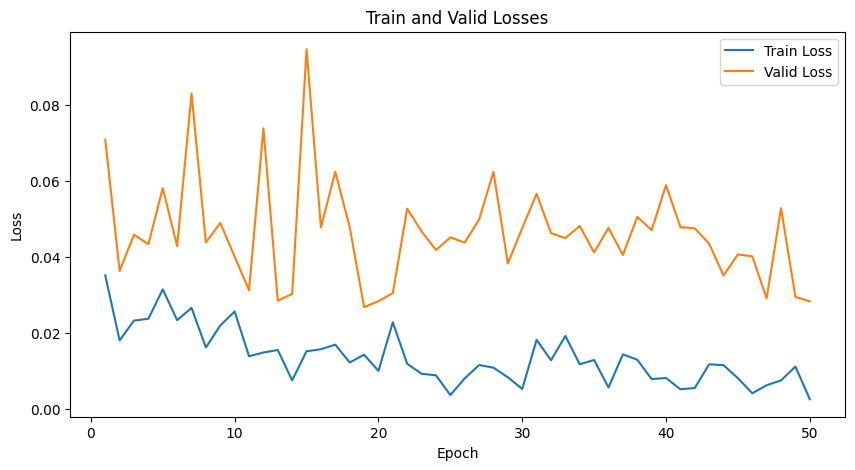

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), eval_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Losses')
plt.legend()
plt.show()

In [ ]:
type(train_accs[0])

builtin_function_or_method

In [ ]:
train_accs = [[value.cpu() for value in row] for row in train_accs]
eval_accs = [[value.cpu() for value in row] for row in eval_accs]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accs, label='Train accuracy')
plt.plot(range(1, num_epochs+1), eval_accs, label='Valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Train and Valid accuracy')
plt.legend()
plt.show()

Label: glass paper

tensor([-10.8792,  12.7102, -10.4116,  29.2125, -12.1935, -11.5357],
       device='cuda:0', grad_fn=<SelectBackward0>)


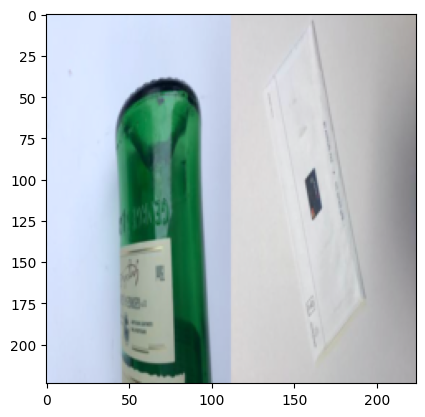

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)

predict_single(test_dataset[66][0])

In [ ]:
random_image_prediction('/content/drive/MyDrive/2023_DeepLearning/random_img.jpg')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


RuntimeError: ignored

### 모델 저장

In [ ]:
torch.save(model, '/content/drive/MyDrive/2023_DeepLearning/model.pth')

## Test: label 비율 확인

In [ ]:
def extract_top_3(label_list, pred_array):
    max_ = pred_array.argsort()[0][-1]
    second_ = pred_array.argsort()[0][-2]
    third_ = pred_array.argsort()[0][-3]

    return [label_list[max_],label_list[second_],label_list[third_]]

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Label: paper

tensor([-28.2987, -24.7389, -27.6547,  23.2007, -28.3803, -23.7379],
       device='cuda:0', grad_fn=<SelectBackward0>)


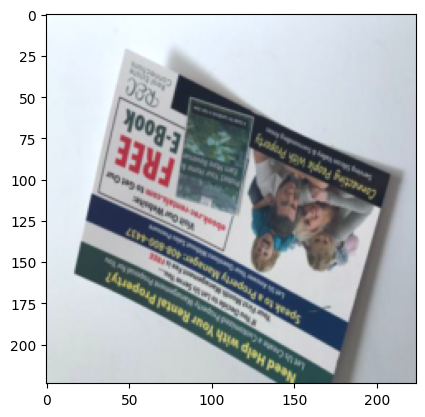

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)

# validation image 예측해보기
predict_single(valid_dataset[100][0]) # checking out the predictions of some images from the validation dataset.

In [ ]:
from PIL import Image
import torchvision.transforms as T

In [ ]:
def random_image_prediction(path): #This function is to see the predictions of random images from internet.
    image = Image.open(path)
    image_tensor = T.ToTensor()(image).unsqueeze(0)
    image_tensor = T.Resize([128,128])(image_tensor)
    image_tensor = T.Normalize(*imagenet_stats)(image_tensor)
    #print(image_tensor.shape)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

In [ ]:
class_labels

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## class별 정확도 체크

In [ ]:
class_correct = [0] * num_classes
class_total = [0] * num_classes

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

class_accs = []

for i in range(num_classes):
    acc = 100.0 * class_correct[i] / class_total[i]
    class_accs.append(acc)
    print(f'Accuracy of {class_labels[i]}: {acc:.2f}%')


Accuracy of cardboard: 78.48%
Accuracy of glass: 79.21%
Accuracy of metal: 70.37%
Accuracy of paper: 78.26%
Accuracy of plastic: 82.83%
Accuracy of trash: 68.75%


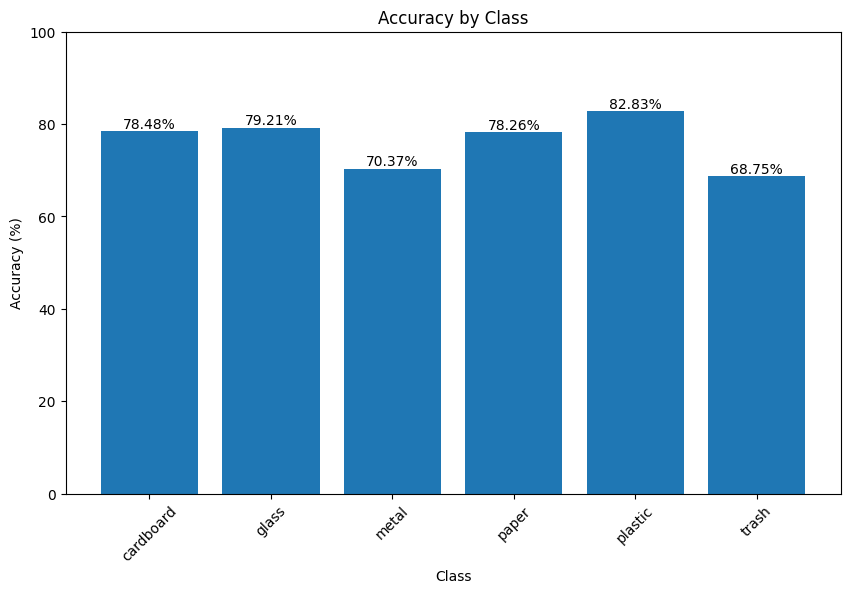

In [ ]:
import matplotlib.pyplot as plt

# 클래스 레이블과 정확도를 막대 그래프에 표시하기 위해 데이터를 준비합니다.
labels = class_labels
accuracies = class_accs

# 막대 그래프를 그립니다.
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Class')

# 막대 그래프에 정확도 값을 표시합니다.
for i in range(len(labels)):
    plt.text(i, accuracies[i], f'{accuracies[i]:.2f}%', ha='center', va='bottom')

plt.ylim([0, 100])  # y축 범위 설정
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show()

## 가중치 fix(마지막 레이어만 학습)

In [ ]:
# i = 0
# for name, param in model.named_parameters():  # named_parameters 가중치 뽑아주는 함수

#     print(i,name)
#     i+= 1

# # 211, 212만 fully connected ->  classifier만

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt

# EfficientNet 모델 불러오기
model = efficientnet_b0(pretrained=True)
num_classes = len(class_labels)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

for param in model.parameters():
  param.requires_grad = False

# 마지막 레이어(fc)의 가중치만 학습 가능하도록 설정
for name, param in model.named_parameters():
  if name.split('.')[0] == 'classifier':
    # print(name)
    param.requires_grad = True


# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 마지막 레이어 가중치 학습 True인지 확인
for name, param in model.named_parameters():
  if param.requires_grad == True:
    print(name, param.requires_grad)

classifier.1.weight True
classifier.1.bias True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 50
train_losses = []
train_accs = []
eval_losses = []
eval_accs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # train으로 학습, valid로 평가
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    eval_loss, eval_acc = evaluate(model, valid_loader, criterion)
    # 그래프 그리기 위한 append
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Eval Loss: {eval_loss:.4f} | Eval Acc: {eval_acc:.4f}')
    #print(f'Eval Loss: {eval_loss:.4f}')
    print('---------------------------------------')

# 테스트 데이터로 모델 평가
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Epoch 1/50


KeyboardInterrupt: ignored

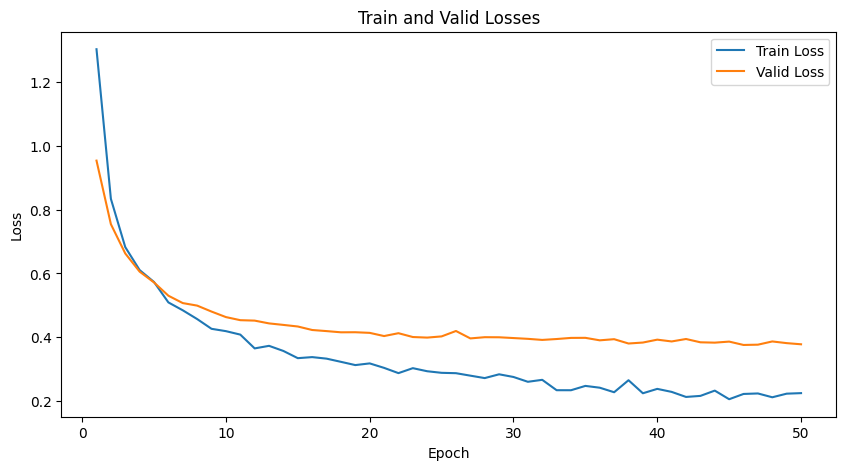

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), eval_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Losses')
plt.legend()
plt.show()

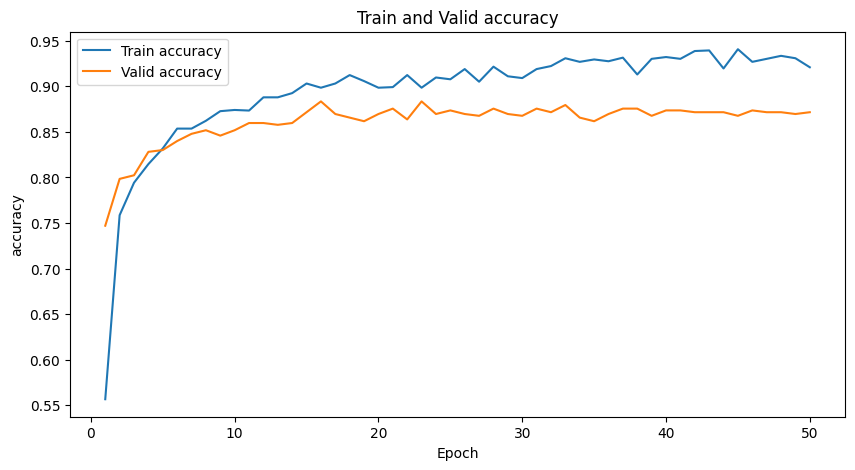

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accs, label='Train accuracy')
plt.plot(range(1, num_epochs+1), eval_accs, label='Valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Train and Valid accuracy')
plt.legend()
plt.show()

결과적으로 fine tuning 한 모델이 더 예측 성능이 좋음

epoch는 15~20번이면 충분할듯

## EfficientNet b1, b2, b3 Test

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(model, loader_train, loader_valid, criterion, optimizer, scheduler=None, epochs=10, save_file='model_state_dict.pth'):

    valid_loss_min = np.inf

    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')

        model.train()
        epoch_train_loss = 0

        for images, labels in tqdm(loader_train):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

        print(f'\t훈련 데이터 손실값 : {epoch_train_loss / len(loader_train):.4f}')

        model.eval()
        epoch_valid_loss = 0
        preds_list = []
        true_list = []

        with torch.no_grad():
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()

                preds = torch.max(outputs, dim=1)[1].cpu().numpy()
                true = labels.cpu().numpy()

                preds_list.extend(preds)
                true_list.extend(true)

        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list, average='macro')
        val_f1_score = f1_score(true_list, preds_list, average='macro')

        print(f'\t검증 데이터 손실값 : {epoch_valid_loss / len(loader_valid):.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')

        if epoch_valid_loss <= valid_loss_min:
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            torch.save(model.state_dict(), save_file)
            valid_loss_min = epoch_valid_loss

    return torch.load(save_file)

In [ ]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=5ec550c6031aac507ca6e18d1eff8bbfd9a1b0ffdc7aa9b8a9ffe028e2b7d806
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
models_list =[] # 모델 저장용 리스트

In [ ]:
len(class_labels)

6

In [ ]:
from efficientnet_pytorch import EfficientNet

# 모델 생성
efficientnet_b1 = EfficientNet.from_pretrained('efficientnet-b1', num_classes=len(class_labels))
efficientnet_b2 = EfficientNet.from_pretrained('efficientnet-b2', num_classes=len(class_labels))
efficientnet_b3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=len(class_labels))

# 장비 할당
efficientnet_b1 = efficientnet_b1.to(device)
efficientnet_b2 = efficientnet_b2.to(device)
efficientnet_b3 = efficientnet_b3.to(device)

# 리스트에 모델 저장
models_list.append(efficientnet_b1)
models_list.append(efficientnet_b2)
models_list.append(efficientnet_b3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 49.5MB/s]
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


Loaded pretrained weights for efficientnet-b1


100%|██████████| 35.1M/35.1M [00:00<00:00, 53.4MB/s]
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


Loaded pretrained weights for efficientnet-b2


100%|██████████| 47.1M/47.1M [00:00<00:00, 54.0MB/s]


Loaded pretrained weights for efficientnet-b3


In [ ]:
for idx, model in enumerate(models_list):
    num_parmas = sum(param.numel() for param in model.parameters())
    print(f'모델{idx+1} 파라미터 개수 : {num_parmas}')

모델1 파라미터 개수 : 6520870
모델2 파라미터 개수 : 7709448
모델3 파라미터 개수 : 10705454


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
models_list[0]

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
optimizer1 = torch.optim.AdamW(models_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(models_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(models_list[2].parameters(), lr=0.0006, weight_decay=0.001)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00


In [ ]:
from transformers import get_cosine_schedule_with_warmup

epochs = 20 # 총 에폭

# 스케줄러
scheduler1 = get_cosine_schedule_with_warmup(optimizer1,
                                    num_warmup_steps=len(train_loader)*3,
                                    num_training_steps=len(train_loader)*epochs)

scheduler2 = get_cosine_schedule_with_warmup(optimizer2,
                                    num_warmup_steps=len(train_loader)*3,
                                    num_training_steps=len(train_loader)*epochs)

scheduler3 = get_cosine_schedule_with_warmup(optimizer3,
                                    num_warmup_steps=len(train_loader)*3,
                                    num_training_steps=len(train_loader)*epochs)

In [ ]:
##################################################################################

In [ ]:
# 첫 번째 모델 훈련
model_state_dict = train(model=models_list[0],
                         loader_train=train_loader,
                         loader_valid=valid_loader,
                         criterion=criterion,
                         optimizer=optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)

# 첫 번째 모델에 최적 가중치 적용
models_list[0].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.85it/s]


	훈련 데이터 손실값 : 0.6561
	검증 데이터 손실값 : 0.6647
	정확도 : 0.7767 / 재현율 : 0.6950 / F1 점수 : 0.6966
	### 검증 데이터 손실값 감소 (inf --> 10.6344). 모델 저장
에폭 [2/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.95it/s]


	훈련 데이터 손실값 : 0.3164
	검증 데이터 손실값 : 0.5009
	정확도 : 0.8300 / 재현율 : 0.7953 / F1 점수 : 0.8130
	### 검증 데이터 손실값 감소 (10.6344 --> 8.0142). 모델 저장
에폭 [3/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.91it/s]


	훈련 데이터 손실값 : 0.1665
	검증 데이터 손실값 : 0.5880
	정확도 : 0.8241 / 재현율 : 0.7752 / F1 점수 : 0.7837
에폭 [4/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.94it/s]


	훈련 데이터 손실값 : 0.1177
	검증 데이터 손실값 : 0.6183
	정확도 : 0.8399 / 재현율 : 0.8208 / F1 점수 : 0.8417
에폭 [5/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.86it/s]


	훈련 데이터 손실값 : 0.0916
	검증 데이터 손실값 : 0.4726
	정확도 : 0.8775 / 재현율 : 0.8505 / F1 점수 : 0.8640
	### 검증 데이터 손실값 감소 (8.0142 --> 7.5622). 모델 저장
에폭 [6/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92it/s]


	훈련 데이터 손실값 : 0.0907
	검증 데이터 손실값 : 0.5966
	정확도 : 0.8518 / 재현율 : 0.8023 / F1 점수 : 0.8151
에폭 [7/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.91it/s]


	훈련 데이터 손실값 : 0.0569
	검증 데이터 손실값 : 0.4366
	정확도 : 0.9190 / 재현율 : 0.9230 / F1 점수 : 0.9152
	### 검증 데이터 손실값 감소 (7.5622 --> 6.9851). 모델 저장
에폭 [8/20] 
-----------------------------


100%|██████████| 48/48 [00:19<00:00,  2.45it/s]


	훈련 데이터 손실값 : 0.0472
	검증 데이터 손실값 : 0.3983
	정확도 : 0.9071 / 재현율 : 0.9012 / F1 점수 : 0.9035
	### 검증 데이터 손실값 감소 (6.9851 --> 6.3724). 모델 저장
에폭 [9/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.90it/s]


	훈련 데이터 손실값 : 0.0344
	검증 데이터 손실값 : 0.3795
	정확도 : 0.9111 / 재현율 : 0.9000 / F1 점수 : 0.9033
	### 검증 데이터 손실값 감소 (6.3724 --> 6.0723). 모델 저장
에폭 [10/20] 
-----------------------------


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


	훈련 데이터 손실값 : 0.0330
	검증 데이터 손실값 : 0.3175
	정확도 : 0.9229 / 재현율 : 0.9162 / F1 점수 : 0.9184
	### 검증 데이터 손실값 감소 (6.0723 --> 5.0803). 모델 저장
에폭 [11/20] 
-----------------------------


100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


	훈련 데이터 손실값 : 0.0414
	검증 데이터 손실값 : 0.3527
	정확도 : 0.9150 / 재현율 : 0.9203 / F1 점수 : 0.9135
에폭 [12/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.92it/s]


	훈련 데이터 손실값 : 0.0219
	검증 데이터 손실값 : 0.2982
	정확도 : 0.9308 / 재현율 : 0.9321 / F1 점수 : 0.9248
	### 검증 데이터 손실값 감소 (5.0803 --> 4.7706). 모델 저장
에폭 [13/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93it/s]


	훈련 데이터 손실값 : 0.0123
	검증 데이터 손실값 : 0.2954
	정확도 : 0.9209 / 재현율 : 0.9204 / F1 점수 : 0.9136
	### 검증 데이터 손실값 감소 (4.7706 --> 4.7267). 모델 저장
에폭 [14/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93it/s]


	훈련 데이터 손실값 : 0.0172
	검증 데이터 손실값 : 0.2691
	정확도 : 0.9348 / 재현율 : 0.9388 / F1 점수 : 0.9299
	### 검증 데이터 손실값 감소 (4.7267 --> 4.3051). 모델 저장
에폭 [15/20] 
-----------------------------


100%|██████████| 48/48 [00:19<00:00,  2.48it/s]


	훈련 데이터 손실값 : 0.0066
	검증 데이터 손실값 : 0.2663
	정확도 : 0.9308 / 재현율 : 0.9351 / F1 점수 : 0.9264
	### 검증 데이터 손실값 감소 (4.3051 --> 4.2607). 모델 저장
에폭 [16/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.86it/s]


	훈련 데이터 손실값 : 0.0063
	검증 데이터 손실값 : 0.2678
	정확도 : 0.9348 / 재현율 : 0.9391 / F1 점수 : 0.9300
에폭 [17/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.93it/s]


	훈련 데이터 손실값 : 0.0113
	검증 데이터 손실값 : 0.2644
	정확도 : 0.9348 / 재현율 : 0.9391 / F1 점수 : 0.9300
	### 검증 데이터 손실값 감소 (4.2607 --> 4.2299). 모델 저장
에폭 [18/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


	훈련 데이터 손실값 : 0.0110
	검증 데이터 손실값 : 0.2645
	정확도 : 0.9328 / 재현율 : 0.9334 / F1 점수 : 0.9262
에폭 [19/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.84it/s]


	훈련 데이터 손실값 : 0.0075
	검증 데이터 손실값 : 0.2657
	정확도 : 0.9328 / 재현율 : 0.9334 / F1 점수 : 0.9262
에폭 [20/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.80it/s]


	훈련 데이터 손실값 : 0.0110
	검증 데이터 손실값 : 0.2659
	정확도 : 0.9328 / 재현율 : 0.9334 / F1 점수 : 0.9262


<All keys matched successfully>

In [ ]:
## 모델1(b1) -> 17번 에폭 모델이 최종 모델

In [ ]:
# 두 번째 모델 훈련
model_state_dict = train(model=models_list[1],
                         loader_train=train_loader,
                         loader_valid=valid_loader,
                         criterion=criterion,
                         optimizer=optimizer2,
                         scheduler=scheduler2,
                         epochs=epochs)

# 두 번째 모델에 최적 가중치 적용
models_list[1].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


	훈련 데이터 손실값 : 1.5954
	검증 데이터 손실값 : 1.1722
	정확도 : 0.7055 / 재현율 : 0.6328 / F1 점수 : 0.6441
	### 검증 데이터 손실값 감소 (inf --> 18.7548). 모델 저장
에폭 [2/20] 
-----------------------------


100%|██████████| 48/48 [00:21<00:00,  2.26it/s]


	훈련 데이터 손실값 : 0.6618
	검증 데이터 손실값 : 0.5284
	정확도 : 0.8379 / 재현율 : 0.7837 / F1 점수 : 0.8093
	### 검증 데이터 손실값 감소 (18.7548 --> 8.4545). 모델 저장
에폭 [3/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.84it/s]


	훈련 데이터 손실값 : 0.2576
	검증 데이터 손실값 : 0.3725
	정확도 : 0.8755 / 재현율 : 0.8344 / F1 점수 : 0.8498
	### 검증 데이터 손실값 감소 (8.4545 --> 5.9595). 모델 저장
에폭 [4/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.88it/s]


	훈련 데이터 손실값 : 0.1616
	검증 데이터 손실값 : 0.3683
	정확도 : 0.8972 / 재현율 : 0.8842 / F1 점수 : 0.8827
	### 검증 데이터 손실값 감소 (5.9595 --> 5.8931). 모델 저장
에폭 [5/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.84it/s]


	훈련 데이터 손실값 : 0.1478
	검증 데이터 손실값 : 0.5011
	정확도 : 0.8696 / 재현율 : 0.8490 / F1 점수 : 0.8529
에폭 [6/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.80it/s]


	훈련 데이터 손실값 : 0.1063
	검증 데이터 손실값 : 0.4404
	정확도 : 0.8874 / 재현율 : 0.8770 / F1 점수 : 0.8786
에폭 [7/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.86it/s]


	훈련 데이터 손실값 : 0.0793
	검증 데이터 손실값 : 0.5150
	정확도 : 0.8696 / 재현율 : 0.8682 / F1 점수 : 0.8627
에폭 [8/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.88it/s]


	훈련 데이터 손실값 : 0.0489
	검증 데이터 손실값 : 0.3589
	정확도 : 0.9190 / 재현율 : 0.9098 / F1 점수 : 0.9057
	### 검증 데이터 손실값 감소 (5.8931 --> 5.7421). 모델 저장
에폭 [9/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.83it/s]


	훈련 데이터 손실값 : 0.0490
	검증 데이터 손실값 : 0.3194
	정확도 : 0.9229 / 재현율 : 0.9259 / F1 점수 : 0.9189
	### 검증 데이터 손실값 감소 (5.7421 --> 5.1100). 모델 저장
에폭 [10/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.85it/s]


	훈련 데이터 손실값 : 0.0511
	검증 데이터 손실값 : 0.3503
	정확도 : 0.9209 / 재현율 : 0.9219 / F1 점수 : 0.9187
에폭 [11/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.80it/s]


	훈련 데이터 손실값 : 0.0281
	검증 데이터 손실값 : 0.3233
	정확도 : 0.9150 / 재현율 : 0.9168 / F1 점수 : 0.9121
에폭 [12/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.89it/s]


	훈련 데이터 손실값 : 0.0123
	검증 데이터 손실값 : 0.2923
	정확도 : 0.9269 / 재현율 : 0.9293 / F1 점수 : 0.9229
	### 검증 데이터 손실값 감소 (5.1100 --> 4.6768). 모델 저장
에폭 [13/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.78it/s]


	훈련 데이터 손실값 : 0.0101
	검증 데이터 손실값 : 0.2772
	정확도 : 0.9289 / 재현율 : 0.9306 / F1 점수 : 0.9226
	### 검증 데이터 손실값 감소 (4.6768 --> 4.4351). 모델 저장
에폭 [14/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.87it/s]


	훈련 데이터 손실값 : 0.0071
	검증 데이터 손실값 : 0.2659
	정확도 : 0.9308 / 재현율 : 0.9308 / F1 점수 : 0.9225
	### 검증 데이터 손실값 감소 (4.4351 --> 4.2552). 모델 저장
에폭 [15/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.80it/s]


	훈련 데이터 손실값 : 0.0059
	검증 데이터 손실값 : 0.2521
	정확도 : 0.9308 / 재현율 : 0.9314 / F1 점수 : 0.9225
	### 검증 데이터 손실값 감소 (4.2552 --> 4.0332). 모델 저장
에폭 [16/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.88it/s]


	훈련 데이터 손실값 : 0.0062
	검증 데이터 손실값 : 0.2469
	정확도 : 0.9387 / 재현율 : 0.9342 / F1 점수 : 0.9306
	### 검증 데이터 손실값 감소 (4.0332 --> 3.9501). 모델 저장
에폭 [17/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.81it/s]


	훈련 데이터 손실값 : 0.0047
	검증 데이터 손실값 : 0.2401
	정확도 : 0.9368 / 재현율 : 0.9285 / F1 점수 : 0.9265
	### 검증 데이터 손실값 감소 (3.9501 --> 3.8413). 모델 저장
에폭 [18/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.88it/s]


	훈련 데이터 손실값 : 0.0059
	검증 데이터 손실값 : 0.2447
	정확도 : 0.9387 / 재현율 : 0.9300 / F1 점수 : 0.9284
에폭 [19/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.85it/s]


	훈련 데이터 손실값 : 0.0043
	검증 데이터 손실값 : 0.2448
	정확도 : 0.9368 / 재현율 : 0.9285 / F1 점수 : 0.9265
에폭 [20/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.89it/s]


	훈련 데이터 손실값 : 0.0067
	검증 데이터 손실값 : 0.2453
	정확도 : 0.9387 / 재현율 : 0.9342 / F1 점수 : 0.9306


<All keys matched successfully>

In [ ]:
## 모델2(b2) -> 17번 에폭 모델이 최종 모델

In [ ]:
# 세 번째 모델 훈련
model_state_dict = train(model=models_list[2],
                         loader_train=train_loader,
                         loader_valid=valid_loader,
                         criterion=criterion,
                         optimizer=optimizer3,
                         scheduler=scheduler3,
                         epochs=epochs)

# 세 번째 모델에 최적 가중치 적용
models_list[2].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.30it/s]


	훈련 데이터 손실값 : 1.5761
	검증 데이터 손실값 : 1.1313
	정확도 : 0.7273 / 재현율 : 0.6620 / F1 점수 : 0.6706
	### 검증 데이터 손실값 감소 (inf --> 18.1006). 모델 저장
에폭 [2/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


	훈련 데이터 손실값 : 0.5809
	검증 데이터 손실값 : 0.4531
	정확도 : 0.8518 / 재현율 : 0.8040 / F1 점수 : 0.8165
	### 검증 데이터 손실값 감소 (18.1006 --> 7.2497). 모델 저장
에폭 [3/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


	훈련 데이터 손실값 : 0.2128
	검증 데이터 손실값 : 0.5336
	정확도 : 0.8518 / 재현율 : 0.7989 / F1 점수 : 0.8194
에폭 [4/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]


	훈련 데이터 손실값 : 0.1749
	검증 데이터 손실값 : 0.5111
	정확도 : 0.8458 / 재현율 : 0.8619 / F1 점수 : 0.8323
에폭 [5/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]


	훈련 데이터 손실값 : 0.1668
	검증 데이터 손실값 : 0.7740
	정확도 : 0.8123 / 재현율 : 0.8105 / F1 점수 : 0.8102
에폭 [6/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


	훈련 데이터 손실값 : 0.1230
	검증 데이터 손실값 : 0.6168
	정확도 : 0.8478 / 재현율 : 0.8491 / F1 점수 : 0.8445
에폭 [7/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


	훈련 데이터 손실값 : 0.0870
	검증 데이터 손실값 : 0.5548
	정확도 : 0.8538 / 재현율 : 0.8604 / F1 점수 : 0.8524
에폭 [8/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.32it/s]


	훈련 데이터 손실값 : 0.0624
	검증 데이터 손실값 : 0.3384
	정확도 : 0.8972 / 재현율 : 0.9129 / F1 점수 : 0.8976
	### 검증 데이터 손실값 감소 (7.2497 --> 5.4152). 모델 저장
에폭 [9/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.30it/s]


	훈련 데이터 손실값 : 0.0364
	검증 데이터 손실값 : 0.3652
	정확도 : 0.9209 / 재현율 : 0.9283 / F1 점수 : 0.9178
에폭 [10/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


	훈련 데이터 손실값 : 0.0252
	검증 데이터 손실값 : 0.3348
	정확도 : 0.9249 / 재현율 : 0.9309 / F1 점수 : 0.9266
	### 검증 데이터 손실값 감소 (5.4152 --> 5.3560). 모델 저장
에폭 [11/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


	훈련 데이터 손실값 : 0.0261
	검증 데이터 손실값 : 0.2639
	정확도 : 0.9427 / 재현율 : 0.9442 / F1 점수 : 0.9398
	### 검증 데이터 손실값 감소 (5.3560 --> 4.2219). 모델 저장
에폭 [12/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.32it/s]


	훈련 데이터 손실값 : 0.0119
	검증 데이터 손실값 : 0.2897
	정확도 : 0.9308 / 재현율 : 0.9346 / F1 점수 : 0.9308
에폭 [13/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.30it/s]


	훈련 데이터 손실값 : 0.0103
	검증 데이터 손실값 : 0.2931
	정확도 : 0.9229 / 재현율 : 0.9270 / F1 점수 : 0.9209
에폭 [14/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


	훈련 데이터 손실값 : 0.0207
	검증 데이터 손실값 : 0.2750
	정확도 : 0.9328 / 재현율 : 0.9318 / F1 점수 : 0.9287
에폭 [15/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


	훈련 데이터 손실값 : 0.0061
	검증 데이터 손실값 : 0.2698
	정확도 : 0.9407 / 재현율 : 0.9402 / F1 점수 : 0.9376
에폭 [16/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.32it/s]


	훈련 데이터 손실값 : 0.0130
	검증 데이터 손실값 : 0.2747
	정확도 : 0.9328 / 재현율 : 0.9377 / F1 점수 : 0.9314
에폭 [17/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.30it/s]


	훈련 데이터 손실값 : 0.0053
	검증 데이터 손실값 : 0.2705
	정확도 : 0.9407 / 재현율 : 0.9435 / F1 점수 : 0.9378
에폭 [18/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.35it/s]


	훈련 데이터 손실값 : 0.0064
	검증 데이터 손실값 : 0.2697
	정확도 : 0.9387 / 재현율 : 0.9421 / F1 점수 : 0.9362
에폭 [19/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


	훈련 데이터 손실값 : 0.0076
	검증 데이터 손실값 : 0.2681
	정확도 : 0.9387 / 재현율 : 0.9421 / F1 점수 : 0.9362
에폭 [20/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.33it/s]


	훈련 데이터 손실값 : 0.0093
	검증 데이터 손실값 : 0.2676
	정확도 : 0.9387 / 재현율 : 0.9421 / F1 점수 : 0.9362


<All keys matched successfully>

In [ ]:
## 모델3(b3) -> 11번 에폭 모델이 최종 모델

In [ ]:
### 모델별 테스트셋 예측

In [ ]:
def predict(model, loader_test, return_true=False):
    model.eval()
    preds_list = []
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad():   # 기울기 계산 비활성화
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            preds = torch.max(outputs, dim=1)[1].cpu().numpy()
            true = labels.cpu().numpy()


            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list

In [ ]:
result1 = predict(model=models_list[0], loader_test=test_loader, return_true=True)
true_list = result1[0]
preds_list1 = result1[1]

print(true_list)
print(preds_list1)

[3, 3, 5, 3, 3, 0, 2, 2, 2, 5, 0, 3, 1, 5, 2, 2, 5, 1, 3, 2, 1, 0, 1, 4, 0, 1, 4, 1, 1, 3, 3, 3, 0, 1, 0, 2, 2, 0, 4, 0, 0, 1, 2, 4, 2, 3, 1, 2, 2, 4, 2, 1, 4, 1, 0, 0, 4, 4, 0, 4, 2, 0, 3, 3, 3, 5, 0, 0, 0, 4, 2, 3, 4, 3, 2, 4, 1, 5, 1, 1, 3, 4, 4, 1, 3, 5, 4, 0, 3, 3, 5, 4, 1, 5, 4, 3, 1, 2, 2, 0, 4, 2, 2, 3, 4, 2, 1, 1, 2, 1, 2, 0, 2, 1, 4, 1, 1, 4, 2, 5, 1, 4, 0, 0, 5, 0, 4, 3, 0, 5, 1, 5, 1, 3, 3, 1, 4, 2, 4, 4, 1, 3, 3, 3, 3, 3, 2, 0, 0, 0, 3, 1, 4, 3, 4, 4, 4, 3, 5, 2, 1, 0, 3, 3, 2, 3, 4, 3, 3, 0, 1, 1, 1, 3, 3, 3, 3, 1, 0, 4, 0, 2, 2, 4, 3, 4, 1, 0, 1, 4, 1, 0, 1, 3, 4, 4, 0, 0, 5, 4, 3, 0, 0, 0, 3, 3, 5, 4, 0, 4, 0, 3, 3, 4, 4, 4, 1, 0, 4, 4, 4, 1, 3, 3, 1, 2, 3, 4, 1, 4, 1, 1, 1, 3, 3, 0, 0, 2, 1, 2, 0, 5, 1, 3, 0, 0, 0, 0, 4, 1, 1, 1, 3, 4, 3, 4, 3, 3, 1, 3, 2, 0, 1, 2, 2, 3, 4, 4, 2, 1, 4, 1, 0, 3, 3, 4, 4, 2, 1, 1, 3, 4, 2, 1, 4, 2, 4, 3, 3, 2, 0, 1, 5, 3, 3, 4, 3, 0, 2, 3, 1, 3, 4, 3, 0, 2, 1, 5, 0, 1, 1, 0, 1, 1, 1, 4, 3, 1, 2, 4, 2, 1, 3, 3, 3, 3, 2, 0, 4, 4, 4, 3, 2, 

In [ ]:
result2 = predict(model=models_list[1], loader_test=test_loader, return_true=True)
true_list = result2[0]
preds_list2 = result2[1]

print(true_list)
print(preds_list2)

[3, 3, 5, 3, 3, 0, 2, 2, 2, 5, 0, 3, 1, 5, 2, 2, 5, 1, 3, 2, 1, 0, 1, 4, 0, 1, 4, 1, 1, 3, 3, 3, 0, 1, 0, 2, 2, 0, 4, 0, 0, 1, 2, 4, 2, 3, 1, 2, 2, 4, 2, 1, 4, 1, 0, 0, 4, 4, 0, 4, 2, 0, 3, 3, 3, 5, 0, 0, 0, 4, 2, 3, 4, 3, 2, 4, 1, 5, 1, 1, 3, 4, 4, 1, 3, 5, 4, 0, 3, 3, 5, 4, 1, 5, 4, 3, 1, 2, 2, 0, 4, 2, 2, 3, 4, 2, 1, 1, 2, 1, 2, 0, 2, 1, 4, 1, 1, 4, 2, 5, 1, 4, 0, 0, 5, 0, 4, 3, 0, 5, 1, 5, 1, 3, 3, 1, 4, 2, 4, 4, 1, 3, 3, 3, 3, 3, 2, 0, 0, 0, 3, 1, 4, 3, 4, 4, 4, 3, 5, 2, 1, 0, 3, 3, 2, 3, 4, 3, 3, 0, 1, 1, 1, 3, 3, 3, 3, 1, 0, 4, 0, 2, 2, 4, 3, 4, 1, 0, 1, 4, 1, 0, 1, 3, 4, 4, 0, 0, 5, 4, 3, 0, 0, 0, 3, 3, 5, 4, 0, 4, 0, 3, 3, 4, 4, 4, 1, 0, 4, 4, 4, 1, 3, 3, 1, 2, 3, 4, 1, 4, 1, 1, 1, 3, 3, 0, 0, 2, 1, 2, 0, 5, 1, 3, 0, 0, 0, 0, 4, 1, 1, 1, 3, 4, 3, 4, 3, 3, 1, 3, 2, 0, 1, 2, 2, 3, 4, 4, 2, 1, 4, 1, 0, 3, 3, 4, 4, 2, 1, 1, 3, 4, 2, 1, 4, 2, 4, 3, 3, 2, 0, 1, 5, 3, 3, 4, 3, 0, 2, 3, 1, 3, 4, 3, 0, 2, 1, 5, 0, 1, 1, 0, 1, 1, 1, 4, 3, 1, 2, 4, 2, 1, 3, 3, 3, 3, 2, 0, 4, 4, 4, 3, 2, 

In [ ]:
result3 = predict(model=models_list[2], loader_test=test_loader, return_true=True)
true_list = result3[0]
preds_list3 = result3[1]

print(true_list)
print(preds_list3)

[3, 3, 5, 3, 3, 0, 2, 2, 2, 5, 0, 3, 1, 5, 2, 2, 5, 1, 3, 2, 1, 0, 1, 4, 0, 1, 4, 1, 1, 3, 3, 3, 0, 1, 0, 2, 2, 0, 4, 0, 0, 1, 2, 4, 2, 3, 1, 2, 2, 4, 2, 1, 4, 1, 0, 0, 4, 4, 0, 4, 2, 0, 3, 3, 3, 5, 0, 0, 0, 4, 2, 3, 4, 3, 2, 4, 1, 5, 1, 1, 3, 4, 4, 1, 3, 5, 4, 0, 3, 3, 5, 4, 1, 5, 4, 3, 1, 2, 2, 0, 4, 2, 2, 3, 4, 2, 1, 1, 2, 1, 2, 0, 2, 1, 4, 1, 1, 4, 2, 5, 1, 4, 0, 0, 5, 0, 4, 3, 0, 5, 1, 5, 1, 3, 3, 1, 4, 2, 4, 4, 1, 3, 3, 3, 3, 3, 2, 0, 0, 0, 3, 1, 4, 3, 4, 4, 4, 3, 5, 2, 1, 0, 3, 3, 2, 3, 4, 3, 3, 0, 1, 1, 1, 3, 3, 3, 3, 1, 0, 4, 0, 2, 2, 4, 3, 4, 1, 0, 1, 4, 1, 0, 1, 3, 4, 4, 0, 0, 5, 4, 3, 0, 0, 0, 3, 3, 5, 4, 0, 4, 0, 3, 3, 4, 4, 4, 1, 0, 4, 4, 4, 1, 3, 3, 1, 2, 3, 4, 1, 4, 1, 1, 1, 3, 3, 0, 0, 2, 1, 2, 0, 5, 1, 3, 0, 0, 0, 0, 4, 1, 1, 1, 3, 4, 3, 4, 3, 3, 1, 3, 2, 0, 1, 2, 2, 3, 4, 4, 2, 1, 4, 1, 0, 3, 3, 4, 4, 2, 1, 1, 3, 4, 2, 1, 4, 2, 4, 3, 3, 2, 0, 1, 5, 3, 3, 4, 3, 0, 2, 3, 1, 3, 4, 3, 0, 2, 1, 5, 0, 1, 1, 0, 1, 1, 1, 4, 3, 1, 2, 4, 2, 1, 3, 3, 3, 3, 2, 0, 4, 4, 4, 3, 2, 

In [ ]:
print('#'*5, 'efficientnet-b1 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list1):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list1, average="macro"): .4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list1, average="macro"): .4f}')

##### efficientnet-b1 모델 예측 결과 평가 점수 #####
정확도 : 0.9307
재현율 :  0.9132
F1 점수 :  0.9134


In [ ]:
print('#'*5, 'efficientnet-b2 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list2):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list2, average="macro"): .4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list2, average="macro"): .4f}')

##### efficientnet-b2 모델 예측 결과 평가 점수 #####
정확도 : 0.9386
재현율 :  0.9131
F1 점수 :  0.9189


In [ ]:
print('#'*5, 'efficientnet-b3 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list3):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list3, average="macro"): .4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list3, average="macro"): .4f}')

##### efficientnet-b3 모델 예측 결과 평가 점수 #####
정확도 : 0.9188
재현율 :  0.8941
F1 점수 :  0.9057


In [ ]:
#################################### 같은 처리로 b0 test############################################

In [ ]:
from efficientnet_pytorch import EfficientNet
efficientnet_b0 = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(class_labels))

efficientnet_b0 = efficientnet_b0.to(device)

criterion = nn.CrossEntropyLoss()
optimizer0 = torch.optim.AdamW(efficientnet_b0.parameters(), lr=0.0006, weight_decay=0.001)

from transformers import get_cosine_schedule_with_warmup

epochs = 20 # 총 에폭

# 스케줄러
scheduler0 = get_cosine_schedule_with_warmup(optimizer0,
                                    num_warmup_steps=len(train_loader)*3,
                                    num_training_steps=len(train_loader)*epochs)

Loaded pretrained weights for efficientnet-b0


In [ ]:
model_state_dict = train(model=efficientnet_b0,
                         loader_train=train_loader,
                         loader_valid=valid_loader,
                         criterion=criterion,
                         optimizer=optimizer0,
                         scheduler=scheduler0,
                         epochs=epochs)

# 최적 가중치 적용
efficientnet_b0.load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


100%|██████████| 48/48 [12:29<00:00, 15.62s/it]


	훈련 데이터 손실값 : 1.5955
	검증 데이터 손실값 : 1.1831
	정확도 : 0.6680 / 재현율 : 0.5877 / F1 점수 : 0.5671
	### 검증 데이터 손실값 감소 (inf --> 18.9298). 모델 저장
에폭 [2/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.08it/s]


	훈련 데이터 손실값 : 0.6929
	검증 데이터 손실값 : 0.6431
	정확도 : 0.7708 / 재현율 : 0.6864 / F1 점수 : 0.6775
	### 검증 데이터 손실값 감소 (18.9298 --> 10.2904). 모델 저장
에폭 [3/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.07it/s]


	훈련 데이터 손실값 : 0.2822
	검증 데이터 손실값 : 0.5170
	정확도 : 0.8221 / 재현율 : 0.7912 / F1 점수 : 0.7961
	### 검증 데이터 손실값 감소 (10.2904 --> 8.2714). 모델 저장
에폭 [4/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.11it/s]


	훈련 데이터 손실값 : 0.1647
	검증 데이터 손실값 : 0.5658
	정확도 : 0.8419 / 재현율 : 0.8096 / F1 점수 : 0.8268
에폭 [5/20] 
-----------------------------


100%|██████████| 48/48 [00:18<00:00,  2.63it/s]


	훈련 데이터 손실값 : 0.1464
	검증 데이터 손실값 : 0.3833
	정확도 : 0.8933 / 재현율 : 0.8683 / F1 점수 : 0.8773
	### 검증 데이터 손실값 감소 (8.2714 --> 6.1323). 모델 저장
에폭 [6/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.09it/s]


	훈련 데이터 손실값 : 0.1058
	검증 데이터 손실값 : 0.2734
	정확도 : 0.9209 / 재현율 : 0.8868 / F1 점수 : 0.9036
	### 검증 데이터 손실값 감소 (6.1323 --> 4.3748). 모델 저장
에폭 [7/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.09it/s]


	훈련 데이터 손실값 : 0.0340
	검증 데이터 손실값 : 0.2986
	정확도 : 0.9111 / 재현율 : 0.9075 / F1 점수 : 0.8967
에폭 [8/20] 
-----------------------------


100%|██████████| 48/48 [00:16<00:00,  2.83it/s]


	훈련 데이터 손실값 : 0.0354
	검증 데이터 손실값 : 0.2392
	정확도 : 0.9348 / 재현율 : 0.9256 / F1 점수 : 0.9251
	### 검증 데이터 손실값 감소 (4.3748 --> 3.8273). 모델 저장
에폭 [9/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.79it/s]


	훈련 데이터 손실값 : 0.0328
	검증 데이터 손실값 : 0.2419
	정확도 : 0.9368 / 재현율 : 0.9175 / F1 점수 : 0.9271
에폭 [10/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.12it/s]


	훈련 데이터 손실값 : 0.0286
	검증 데이터 손실값 : 0.2727
	정확도 : 0.9328 / 재현율 : 0.9093 / F1 점수 : 0.9232
에폭 [11/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.09it/s]


	훈련 데이터 손실값 : 0.0211
	검증 데이터 손실값 : 0.2347
	정확도 : 0.9328 / 재현율 : 0.9312 / F1 점수 : 0.9262
	### 검증 데이터 손실값 감소 (3.8273 --> 3.7545). 모델 저장
에폭 [12/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.09it/s]


	훈련 데이터 손실값 : 0.0170
	검증 데이터 손실값 : 0.2232
	정확도 : 0.9427 / 재현율 : 0.9398 / F1 점수 : 0.9384
	### 검증 데이터 손실값 감소 (3.7545 --> 3.5711). 모델 저장
에폭 [13/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.32it/s]


	훈련 데이터 손실값 : 0.0108
	검증 데이터 손실값 : 0.2207
	정확도 : 0.9387 / 재현율 : 0.9320 / F1 점수 : 0.9305
	### 검증 데이터 손실값 감소 (3.5711 --> 3.5317). 모델 저장
에폭 [14/20] 
-----------------------------


100%|██████████| 48/48 [00:18<00:00,  2.53it/s]


	훈련 데이터 손실값 : 0.0083
	검증 데이터 손실값 : 0.2095
	정확도 : 0.9427 / 재현율 : 0.9353 / F1 점수 : 0.9327
	### 검증 데이터 손실값 감소 (3.5317 --> 3.3527). 모델 저장
에폭 [15/20] 
-----------------------------


100%|██████████| 48/48 [00:24<00:00,  1.92it/s]


	훈련 데이터 손실값 : 0.0198
	검증 데이터 손실값 : 0.1967
	정확도 : 0.9486 / 재현율 : 0.9407 / F1 점수 : 0.9455
	### 검증 데이터 손실값 감소 (3.3527 --> 3.1471). 모델 저장
에폭 [16/20] 
-----------------------------


100%|██████████| 48/48 [00:20<00:00,  2.39it/s]


	훈련 데이터 손실값 : 0.0104
	검증 데이터 손실값 : 0.1987
	정확도 : 0.9506 / 재현율 : 0.9427 / F1 점수 : 0.9434
에폭 [17/20] 
-----------------------------


100%|██████████| 48/48 [00:17<00:00,  2.78it/s]


	훈련 데이터 손실값 : 0.0096
	검증 데이터 손실값 : 0.1986
	정확도 : 0.9466 / 재현율 : 0.9349 / F1 점수 : 0.9395
에폭 [18/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.11it/s]


	훈련 데이터 손실값 : 0.0067
	검증 데이터 손실값 : 0.1984
	정확도 : 0.9466 / 재현율 : 0.9389 / F1 점수 : 0.9399
에폭 [19/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.09it/s]


	훈련 데이터 손실값 : 0.0047
	검증 데이터 손실값 : 0.1954
	정확도 : 0.9506 / 재현율 : 0.9428 / F1 점수 : 0.9434
	### 검증 데이터 손실값 감소 (3.1471 --> 3.1257). 모델 저장
에폭 [20/20] 
-----------------------------


100%|██████████| 48/48 [00:15<00:00,  3.17it/s]


	훈련 데이터 손실값 : 0.0056
	검증 데이터 손실값 : 0.1954
	정확도 : 0.9506 / 재현율 : 0.9428 / F1 점수 : 0.9434


<All keys matched successfully>

In [ ]:
# 모델 b0 -> 19번 에폭에서 모델 저장

In [ ]:
result0 = predict(model=efficientnet_b0, loader_test=test_loader, return_true=True)
true_list = result0[0]
preds_list0 = result0[1]

print(true_list)
print(preds_list0)

[2, 1, 2, 1, 0, 0, 2, 4, 1, 5, 4, 5, 4, 2, 3, 1, 3, 1, 2, 4, 3, 2, 1, 1, 3, 2, 3, 1, 1, 1, 4, 2, 3, 3, 4, 3, 3, 4, 3, 0, 1, 4, 0, 0, 2, 0, 1, 1, 0, 3, 2, 4, 3, 1, 0, 0, 1, 1, 3, 2, 3, 3, 2, 3, 0, 2, 0, 3, 1, 3, 3, 4, 4, 0, 4, 3, 0, 1, 1, 2, 2, 2, 4, 4, 4, 0, 0, 0, 0, 1, 3, 2, 3, 1, 2, 0, 4, 3, 0, 0, 2, 0, 4, 4, 3, 0, 3, 1, 3, 0, 0, 4, 4, 5, 4, 3, 4, 0, 0, 5, 3, 3, 0, 1, 3, 1, 1, 3, 1, 2, 4, 0, 0, 2, 0, 0, 3, 3, 2, 2, 3, 3, 4, 0, 4, 1, 4, 0, 1, 2, 1, 0, 3, 1, 0, 2, 3, 2, 3, 2, 1, 3, 3, 1, 5, 3, 0, 4, 1, 3, 0, 3, 3, 4, 0, 0, 4, 3, 0, 3, 2, 4, 2, 0, 3, 0, 1, 0, 1, 1, 3, 3, 0, 3, 4, 0, 1, 3, 1, 4, 4, 3, 0, 5, 1, 1, 3, 0, 2, 0, 4, 4, 2, 3, 2, 2, 0, 1, 1, 0, 5, 1, 2, 0, 3, 3, 0, 5, 1, 4, 4, 3, 3, 2, 4, 0, 1, 1, 4, 0, 2, 3, 0, 4, 0, 3, 0, 3, 4, 1, 1, 4, 4, 2, 0, 2, 4, 3, 1, 0, 0, 3, 3, 1, 3, 2, 3, 5, 3, 0, 3, 0, 1, 2, 0, 2, 3, 2, 0, 1, 1, 1, 2, 4, 0, 2, 2, 0, 2, 2, 3, 3, 1, 5, 1, 4, 4, 0, 4, 2, 2, 0, 4, 1, 2, 4, 4, 3, 0, 5, 0, 2, 1, 1, 3, 4, 4, 1, 4, 2, 1, 3, 3, 3, 5, 0, 2, 2, 4, 0, 1, 3, 0, 

In [ ]:
print('#'*5, 'efficientnet-b0 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list0):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list0, average="macro"): .4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list0, average="macro"): .4f}')

##### efficientnet-b0 모델 예측 결과 평가 점수 #####
정확도 : 0.9406
재현율 :  0.9258
F1 점수 :  0.9313
